In [316]:
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt

In [184]:
# Rock Paper Scissors actions
action_to_descr = 'RPS'
n_act = len(action_to_descr)

In [185]:
def rewards(a1, a2):
    """Rock paper scissors game."""
    a1 = action_to_descr[a1]
    a2 = action_to_descr[a2]
    if a1 == a2:
        return (0, 0)
    outcomes = {'RP': (-1, 1),
     'RS': (1, -1),
     'PS': (-1, 1),
     
    }
    a1a2 = a1 + a2
    a2a1 = a1a2[::-1]
    if a1a2 in outcomes:
        return outcomes[a1a2]
    elif a2a1 in outcomes:
        return outcomes[a2a1][::-1]
    else:
        raise Exception("Unkown action pair %s" % a1a2)

## All outcomes (sanity check)

In [249]:
for a1 in range(n_act):
    for a2 in range(n_act):
        r = rewards(a1, a2)
        ad1 = action_to_descr[a1]
        ad2 = action_to_descr[a2]
        descr = ""
        if r[0] > r[1]:
            descr = "%s wins" % ad1
        elif r[1] > r[0]:
            descr = "%s loses" % ad1
        else:
            descr = "tie"
        print("%s vs %s => %s" % (ad1, ad2, descr))

R vs R => tie
R vs P => R loses
R vs S => R wins
P vs R => P wins
P vs P => tie
P vs S => P loses
S vs R => S loses
S vs P => S wins
S vs S => tie


## Agent and environment

In [300]:
class RPCAgent(object):
    """Rock Paper Scissors agent."""
    def __init__(self, noise_dim, identity=None):
        self.noise_dim = noise_dim
        self.identity = identity
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_shape=(self.noise_dim,), activation='relu'),
            tf.keras.layers.Dense(n_act, activation=None),
          tf.keras.layers.Softmax(),
        ])
        
        self.data = []
    def step(self, xi):
        p = self.model(np.array([xi]))[0].numpy()
        p = p / np.sum(p)
        return np.random.choice(range(n_act), p=p)

    def register_episode(self, h, opponent=None):
        self.data.append(deepcopy(list(h)) + [opponent])
        self._train()
        
    def _train(self):
        pass
    
    def __repr__(self):
        opponents = np.unique([x[-1].identity for x in self.data])
        return "<Agent id=%d wisdom=%d opponents=%d>" % (self.identity, len(self.data),
                                            len(opponents))

class RPCEnv(object):
    """Rock paper scissors environment."""
    def __init__(self, noise_dim=10):
        self.noise_dim = noise_dim
    def reset(self):
        pass
    def step(self, a1, a2):
        R = rewards(a1, a2)
        assert np.sum(R) == 0
        return R
    def reset(self):
        return np.random.randn(self.noise_dim)
    def __repr__(self):
        return "<Env noise_dim=%d>" % self.noise_dim
    
class Universe(object):
    """Interaction between 2 agents in the environment."""
    def __init__(self, environment, agents, monitor):
        self.environment = environment
        self.monitor = monitor
        self.agents = agents
        assert len(self.agents) == 2
        
    def episode(self):
        xi = self.environment.reset()
        a1 = self.agents[0].step(xi)
        a2 = self.agents[1].step(xi)
        rews = self.environment.step(a1, a2)
        episode = (xi, a1, a2, rews)
        self.agents[0].register_episode(episode, opponent=self.agents[1])
        self.agents[1].register_episode(episode, opponent=self.agents[0])
        self.monitor.register(A1=self.agents[0],
                              A2=self.agents[1],
                              episode=episode)
        return rews
    
    def __repr__(self):
        return "<Universe\n  Environment=%s\n  Agents=%s\n>" % (self.environment, self.agents)
    
class Monitor(object):
    """Tracks agent's performance."""
    def __init__(self, agents):
        self.agents = agents
        self.data = []
        
    def register(self, A1, A2, episode):
        assert A1 in self.agents
        assert A2 in self.agents
        self.data.append([A1, A2, deepcopy(episode)])
        
    def stats(self):
        action_stats = {A: [0 for _ in range(n_act)] for A in self.agents}
        reward_stats = {A: {x: 0 for x in [-1, 0, 1]} for A in self.agents}

        for (A1, A2, (xi, a1, a2, (r1, r2))) in m.data:
            action_stats[A1][a1] += 1
            action_stats[A2][a2] += 1
            reward_stats[A1][r1] += 1
            reward_stats[A2][r2] += 1
            
        return {'reward': reward_stats,
                'action': action_stats}
        
    def __repr__(self):
        return "<Monitor games=%d>" % len(self.data)

In [301]:
# environment
env = RPCEnv(noise_dim=4)

# how many agents to create?
N_AGENTS = 10

# how many games to play during test?
N_GAMES = 100

# creating agents
AGENTS = [RPCAgent(noise_dim=env.noise_dim, identity=i) for i in range(N_AGENTS)]

# to track the performance
m = Monitor(agents=AGENTS)

In [302]:
def sample_agent():
    """Get one of the agents."""
    return np.random.choice(AGENTS)

In [303]:
# Running training games
for _ in tqdm(range(N_GAMES)):
    A1, A2 = sample_agent(), sample_agent()
    U = Universe(environment=env, agents=[A1, A2], monitor=m)
    rew = U.episode()
    del U

In [304]:
AGENTS

[<Agent id=0 wisdom=24 opponents=9>,
 <Agent id=1 wisdom=22 opponents=8>,
 <Agent id=2 wisdom=19 opponents=7>,
 <Agent id=3 wisdom=23 opponents=9>,
 <Agent id=4 wisdom=26 opponents=10>,
 <Agent id=5 wisdom=16 opponents=7>,
 <Agent id=6 wisdom=24 opponents=8>,
 <Agent id=7 wisdom=15 opponents=8>,
 <Agent id=8 wisdom=18 opponents=8>,
 <Agent id=9 wisdom=13 opponents=6>]

## Train stats

In [305]:
m.stats()

{'reward': {<Agent id=0 wisdom=24 opponents=9>: {-1: 8, 0: 8, 1: 8},
  <Agent id=1 wisdom=22 opponents=8>: {-1: 7, 0: 6, 1: 9},
  <Agent id=2 wisdom=19 opponents=7>: {-1: 5, 0: 7, 1: 7},
  <Agent id=3 wisdom=23 opponents=9>: {-1: 5, 0: 8, 1: 10},
  <Agent id=4 wisdom=26 opponents=10>: {-1: 8, 0: 11, 1: 7},
  <Agent id=5 wisdom=16 opponents=7>: {-1: 7, 0: 6, 1: 3},
  <Agent id=6 wisdom=24 opponents=8>: {-1: 9, 0: 12, 1: 3},
  <Agent id=7 wisdom=15 opponents=8>: {-1: 6, 0: 3, 1: 6},
  <Agent id=8 wisdom=18 opponents=8>: {-1: 4, 0: 10, 1: 4},
  <Agent id=9 wisdom=13 opponents=6>: {-1: 4, 0: 3, 1: 6}},
 'action': {<Agent id=0 wisdom=24 opponents=9>: [6, 13, 5],
  <Agent id=1 wisdom=22 opponents=8>: [3, 12, 7],
  <Agent id=2 wisdom=19 opponents=7>: [8, 3, 8],
  <Agent id=3 wisdom=23 opponents=9>: [7, 8, 8],
  <Agent id=4 wisdom=26 opponents=10>: [5, 9, 12],
  <Agent id=5 wisdom=16 opponents=7>: [5, 6, 5],
  <Agent id=6 wisdom=24 opponents=8>: [5, 6, 13],
  <Agent id=7 wisdom=15 opponents=8>

## TESTING TIME!

In [339]:
# our agent
A = AGENTS[0]

# number of games to test for each agent
N_TEST_GAMES = 10

# to track the performance
m_test = Monitor(agents=AGENTS)

# Running training games
for _ in tqdm(range(N_TEST_GAMES)):
    for A2 in AGENTS[1:]:
        U = Universe(environment=env, agents=[A, A2], monitor=m_test)
        rew = U.episode()
        del U

In [340]:
results = {x: y[AGENTS[0]] for x, y in m_test.stats().items()}

In [341]:
results['action']

[6, 13, 5]

In [342]:
rew = results['reward']

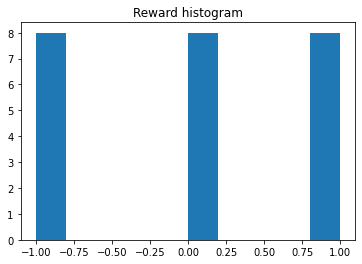

In [344]:
plt.title("Reward histogram")
plt.hist([x for x, y in rew.items() for _ in range(y)])
plt.show()

In [337]:
rew

{-1: 8, 0: 8, 1: 8}